In [60]:
import csv

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

tf.device('/gpu:0')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
RANDOM_SEED = 42

Num GPUs Available:  0


# Specify each path

In [61]:
dataset = '../model/keypoint_classifier/keypoint.csv'
model_save_path = '../model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = '../model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [62]:
NUM_CLASSES = 6

# Dataset reading

In [63]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [64]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\3345009797.py:1: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Xử lý dữ liệu

## THỐNG KÊ VÀ TÌM HIỂU DỮ LIỆU

---

In [66]:
X_dataset_check = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(0, (21 * 2) + 1)))
X_dataset_check = pd.DataFrame(X_dataset_check)
print(X_dataset_check)

        0    1    2         3         4         5         6         7   \
0      0.0  1.0  2.0  3.000000  4.000000  5.000000  6.000000  7.000000   
1      0.0  1.0  2.0  3.000000  4.000000  5.000000  6.000000  7.000000   
2      0.0  0.0  0.0 -0.142105  0.026316 -0.294737 -0.005263 -0.315789   
3      0.0  0.0  0.0 -0.142857  0.021978 -0.302198 -0.027473 -0.313187   
4      0.0  0.0  0.0 -0.150838  0.016760 -0.307263 -0.039106 -0.318436   
...    ...  ...  ...       ...       ...       ...       ...       ...   
21941  5.0  0.0  0.0  0.315315 -0.090090  0.558559 -0.387387  0.594595   
21942  5.0  0.0  0.0  0.223464 -0.061453  0.363128 -0.262570  0.413408   
21943  5.0  0.0  0.0  0.165493 -0.059859  0.274648 -0.246479  0.204225   
21944  5.0  0.0  0.0 -0.030675 -0.104294 -0.012270 -0.276074  0.122699   
21945  5.0  0.0  0.0 -0.185714 -0.121429 -0.314286 -0.342857 -0.250000   

             8         9   ...         33         34         35         36  \
0      8.000000  9.000000  ...  3

In [67]:
X_dataset_check.groupby(0).size()


0
0.0    4699
1.0    3449
2.0    3605
3.0    3306
4.0    3497
5.0    3390
dtype: int64

In [68]:
X_dataset_check = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(0, (21 * 2) + 1)))
X_dataset_check = pd.DataFrame(X_dataset_check)
X_dataset_check = X_dataset_check.sort_values(by=0)
X_dataset_check[0].value_counts()


0
0.0    4699
2.0    3605
4.0    3497
1.0    3449
5.0    3390
3.0    3306
Name: count, dtype: int64

In [69]:
X_dataset_check.head(15)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.0,1.0,2.0,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,33.000000,34.000000,35.000000,36.000000,37.000000,38.000000,39.000000,40.000000,41.000000,42.000000
3137,0.0,0.0,0.0,-0.159763,-0.124260,-0.278107,-0.325444,-0.366864,-0.461538,-0.467456,...,0.076923,-0.940828,0.165680,-0.408284,0.236686,-0.538462,0.248521,-0.639053,0.236686,-0.745562
3136,0.0,0.0,0.0,-0.166667,-0.141975,-0.277778,-0.345679,-0.370370,-0.481481,-0.475309,...,0.030864,-0.956790,0.166667,-0.432099,0.240741,-0.567901,0.246914,-0.672840,0.222222,-0.783951
3135,0.0,0.0,0.0,-0.122378,-0.108392,-0.227273,-0.307692,-0.171329,-0.468531,-0.027972,...,-0.003497,-0.272727,0.209790,-0.395105,0.139860,-0.440559,0.073427,-0.318182,0.076923,-0.258741
3134,0.0,0.0,0.0,0.132184,-0.120690,0.189655,-0.298851,0.247126,-0.448276,0.304598,...,-0.229885,-0.936782,-0.160920,-0.385057,-0.224138,-0.534483,-0.241379,-0.649425,-0.247126,-0.758621
3133,0.0,0.0,0.0,-0.176056,-0.246479,-0.183099,-0.457746,-0.190141,-0.591549,-0.225352,...,-0.281690,-1.000000,0.063380,-0.422535,0.028169,-0.598592,-0.021127,-0.718310,-0.084507,-0.838028
3132,0.0,0.0,0.0,0.131429,-0.120000,0.188571,-0.297143,0.245714,-0.434286,0.314286,...,-0.240000,-0.937143,-0.171429,-0.388571,-0.228571,-0.537143,-0.251429,-0.651429,-0.262857,-0.760000
3138,0.0,0.0,0.0,-0.072727,-0.206061,-0.072727,-0.406061,-0.012121,-0.557576,0.060606,...,0.109091,-0.866667,0.157576,-0.296970,0.193939,-0.472727,0.230303,-0.581818,0.266667,-0.684848
3131,0.0,0.0,0.0,-0.153333,-0.173333,-0.240000,-0.393333,-0.313333,-0.540000,-0.400000,...,-0.040000,-1.000000,0.180000,-0.453333,0.240000,-0.606667,0.233333,-0.726667,0.186667,-0.840000
3129,0.0,0.0,0.0,-0.171429,-0.250000,-0.171429,-0.450000,-0.207143,-0.571429,-0.264286,...,-0.328571,-0.985714,0.021429,-0.421429,-0.021429,-0.607143,-0.071429,-0.735714,-0.128571,-0.850000


In [70]:
# In thông tin các cột trong DF => không tồn tại kiểu dự liệu phi số, không sữ liệu rỗng, dữ liệu đã được tiền xử lý
X_dataset_check.info()
print('Shape tập dữ liệu: ', X_dataset_check.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 21946 entries, 0 to 21945
Data columns (total 43 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       21946 non-null  float32
 1   1       21946 non-null  float32
 2   2       21946 non-null  float32
 3   3       21946 non-null  float32
 4   4       21946 non-null  float32
 5   5       21946 non-null  float32
 6   6       21946 non-null  float32
 7   7       21946 non-null  float32
 8   8       21946 non-null  float32
 9   9       21946 non-null  float32
 10  10      21946 non-null  float32
 11  11      21946 non-null  float32
 12  12      21946 non-null  float32
 13  13      21946 non-null  float32
 14  14      21946 non-null  float32
 15  15      21946 non-null  float32
 16  16      21946 non-null  float32
 17  17      21946 non-null  float32
 18  18      21946 non-null  float32
 19  19      21946 non-null  float32
 20  20      21946 non-null  float32
 21  21      21946 non-null  float32
 22  22 

## Check số lượng các nhãn
---

          Nhãn  Quy đổi
0      Nothing      0.0
1      Nothing      0.0
2      Nothing      0.0
3      Nothing      0.0
4      Nothing      0.0
...        ...      ...
21941    Click      5.0
21942    Click      5.0
21943    Click      5.0
21944    Click      5.0
21945    Click      5.0

[21946 rows x 2 columns]


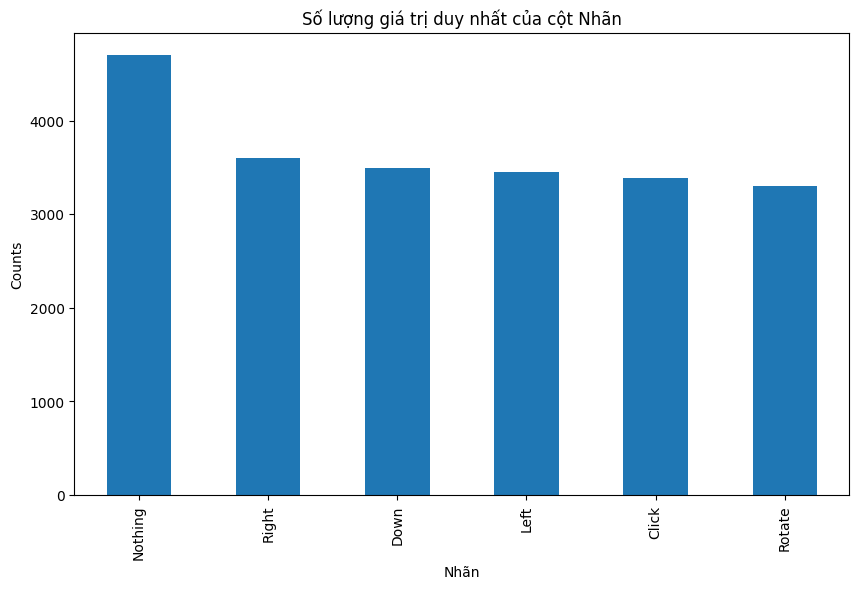

-----------------------------------------------
Số các giá trị duy nhất của cột Nhãn:
Nhãn
Nothing    4699
Right      3605
Down       3497
Left       3449
Click      3390
Rotate     3306
Name: count, dtype: int64


In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

def categories_counts(label_name, dataset):
    print(f'-----------------------------------------------')
    print(f'Số các giá trị duy nhất của cột {label_name}:')
    print(dataset[label_name].value_counts())
    
def plt_categories_counts(label_name, dataset):
    counts = dataset[label_name].value_counts()
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar')
    plt.title(f'Số lượng giá trị duy nhất của cột {label_name}')
    plt.xlabel(label_name)
    plt.ylabel('Counts')
    plt.show()
    categories_counts(label_name, dataset)

label = X_dataset_check[0]
label = pd.DataFrame(label)

a = len(label)
new_column = [None] * len(label)
new_column = pd.DataFrame(new_column)
label = pd.concat([new_column,label],axis=1)
label.columns = ['Nhãn', 'Quy đổi']

label.loc[label['Quy đổi'] == 0, 'Nhãn'] = 'Nothing'
label.loc[label['Quy đổi'] == 1, 'Nhãn'] = 'Left'
label.loc[label['Quy đổi'] == 2, 'Nhãn'] = 'Right'
label.loc[label['Quy đổi'] == 3, 'Nhãn'] = 'Rotate'
label.loc[label['Quy đổi'] == 4, 'Nhãn'] = 'Down'
label.loc[label['Quy đổi'] == 5, 'Nhãn'] = 'Click'

print(label)

# Đếm các giá trị duy nhất của các cột có Nhãn 
plt_categories_counts('Nhãn', label)


## Kiểm tra mức độ sạch của dữ liệu
---

In [72]:
def statistical_missing_data(dataFrame):
    missing_data = dataFrame.isnull().sum()
    duplicate_data = dataFrame.duplicated().sum()

    print("Số liệu thiếu trong mỗi cột:")
    print(missing_data)
    print("\nSố liệu trùng lặp:")
    print(duplicate_data)

# Thống kê dữ liệu khuyết
statistical_missing_data(X_dataset_check)
print(X_dataset_check)

Số liệu thiếu trong mỗi cột:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
dtype: int64

Số liệu trùng lặp:
2
        0    1    2         3         4         5         6         7   \
0      0.0  1.0  2.0  3.000000  4.000000  5.000000  6.000000  7.000000   
3137   0.0  0.0  0.0 -0.159763 -0.124260 -0.278107 -0.325444 -0.366864   
3136   0.0  0.0  0.0 -0.166667 -0.141975 -0.277778 -0.345679 -0.370370   
3135   0.0  0.0  0.0 -0.122378 -0.108392 -0.227273 -0.307692 -0.171329   
3134   0.0  0.0  0.0  0.132184 -0.120690  0.189655 -0.298851  0.247126   
...    ...  ...  ...       ...       ...       ...       ...       ...   
19689  5.0  0.0  0.0 -0.166667 -0.083333 -0.256944 -0.256944 -0.208333   


In [73]:
def plt_statistics_missing_data(dataFrame):
    # Dữ liệu khuyết
    missing_data = dataFrame.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    plt.figure(figsize=(10, 5))
    missing_data.plot(kind='bar')
    plt.title('Dữ liệu khuyết trong mỗi cột')
    plt.xlabel('Tên cột')
    plt.ylabel('Số lượng dữ liệu khuyết')
    plt.show()

    # Dữ liệu lặp
    duplicate_data = dataFrame.duplicated().sum()
    print("\nSố liệu trùng lặp:", duplicate_data)

# Thống kê dữ liệu khuyết
# plt_statistics_missing_data(X_dataset_check)
missing_data = X_dataset_check.isnull().sum()
print(missing_data)


0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
dtype: int64


In [74]:
X_dataset_check.describe()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
count,21946.000000,21946.000000,21946.000000,21946.000000,21946.000000,21946.000000,21946.000000,21946.000000,21946.000000,21946.000000,...,21946.000000,21946.000000,21946.000000,21946.000000,21946.000000,21946.000000,21946.000000,21946.000000,21946.000000,21946.000000
mean,2.347353,0.000091,0.000182,-0.004670,-0.104644,-0.006255,-0.280329,-0.006593,-0.436320,-0.010049,...,-0.012694,-0.471915,-0.002313,-0.466280,-0.004498,-0.577454,-0.003279,-0.570571,-0.003450,-0.595288
std,1.752410,0.009546,0.019091,0.229987,0.127417,0.409006,0.237522,0.496605,0.323002,0.520328,...,0.408640,0.459911,0.429678,0.421954,0.478443,0.478650,0.492918,0.503511,0.512131,0.545705
min,0.000000,0.000000,0.000000,-0.544304,-0.561404,-0.873563,-0.938596,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-0.931507,-1.000000,-1.000000,-1.000000,-0.992908,-1.000000,-1.000000,-1.000000
25%,1.000000,0.000000,0.000000,-0.190955,-0.174016,-0.318182,-0.391635,-0.367134,-0.581551,-0.357143,...,-0.161896,-0.627875,-0.187229,-0.581895,-0.199298,-0.752732,-0.194444,-0.807175,-0.187500,-0.909461
50%,2.000000,0.000000,0.000000,-0.060558,-0.120773,-0.072993,-0.322727,-0.045833,-0.491304,-0.007422,...,-0.018349,-0.441646,-0.025210,-0.495122,-0.022676,-0.664360,-0.023729,-0.666667,-0.028085,-0.634345
75%,4.000000,0.000000,0.000000,0.185053,-0.057554,0.300000,-0.233914,0.346515,-0.397602,0.326446,...,0.114094,-0.312735,0.168780,-0.396761,0.178357,-0.488696,0.168182,-0.418033,0.163412,-0.380392
max,5.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,33.000000,34.000000,35.000000,36.000000,37.000000,38.000000,39.000000,40.000000,41.000000,42.000000


In [75]:
# find the correlation among the columns in the Dataframe
X_dataset_check.corr()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,1.000000,-0.012787,-0.012787,-0.019028,0.026770,-0.003638,-0.037497,0.004316,-0.086454,0.010064,...,-0.010595,-0.058579,0.003644,-0.148163,0.004477,-0.189186,-0.002772,-0.202260,-0.004833,-0.213629
1,-0.012787,1.000000,1.000000,0.124727,0.307551,0.116856,0.252432,0.134698,0.249353,0.165317,...,0.771270,0.715575,0.777713,0.825073,0.738396,0.769453,0.755426,0.769250,0.764371,0.745149
2,-0.012787,1.000000,1.000000,0.124727,0.307551,0.116856,0.252432,0.134698,0.249353,0.165317,...,0.771270,0.715575,0.777713,0.825073,0.738396,0.769453,0.755426,0.769250,0.764371,0.745149
3,-0.019028,0.124727,0.124727,1.000000,0.051443,0.983302,0.015416,0.948648,0.002153,0.883253,...,0.253276,0.062087,-0.144920,0.063312,-0.027526,0.048777,-0.007352,0.064328,-0.018141,0.063063
4,0.026770,0.307551,0.307551,0.051443,1.000000,0.044068,0.941850,0.038360,0.850701,0.033512,...,0.239760,0.473478,0.247067,0.299193,0.242315,0.343528,0.244377,0.367710,0.244305,0.351480
5,-0.003638,0.116856,0.116856,0.983302,0.044068,1.000000,0.008320,0.984516,-0.005076,0.927442,...,0.305488,0.050097,-0.074684,0.057853,0.043450,0.043085,0.056584,0.058567,0.044204,0.058584
6,-0.037497,0.252432,0.252432,0.015416,0.941850,0.008320,1.000000,0.008185,0.971759,0.011015,...,0.204782,0.497168,0.223803,0.387930,0.214863,0.446505,0.214979,0.431108,0.216046,0.398585
7,0.004316,0.134698,0.134698,0.948648,0.038360,0.984516,0.008185,1.000000,-0.000389,0.975019,...,0.351325,0.062072,-0.006735,0.076600,0.115423,0.058132,0.125180,0.070249,0.111668,0.069583
8,-0.086454,0.249353,0.249353,0.002153,0.850701,-0.005076,0.971759,-0.000389,1.000000,0.009575,...,0.206266,0.509205,0.229368,0.458739,0.219279,0.523628,0.218052,0.486043,0.218686,0.443410
9,0.010064,0.165317,0.165317,0.883253,0.033512,0.927442,0.011015,0.975019,0.009575,1.000000,...,0.378944,0.086905,0.054118,0.106078,0.174319,0.085112,0.182748,0.094721,0.169459,0.093061


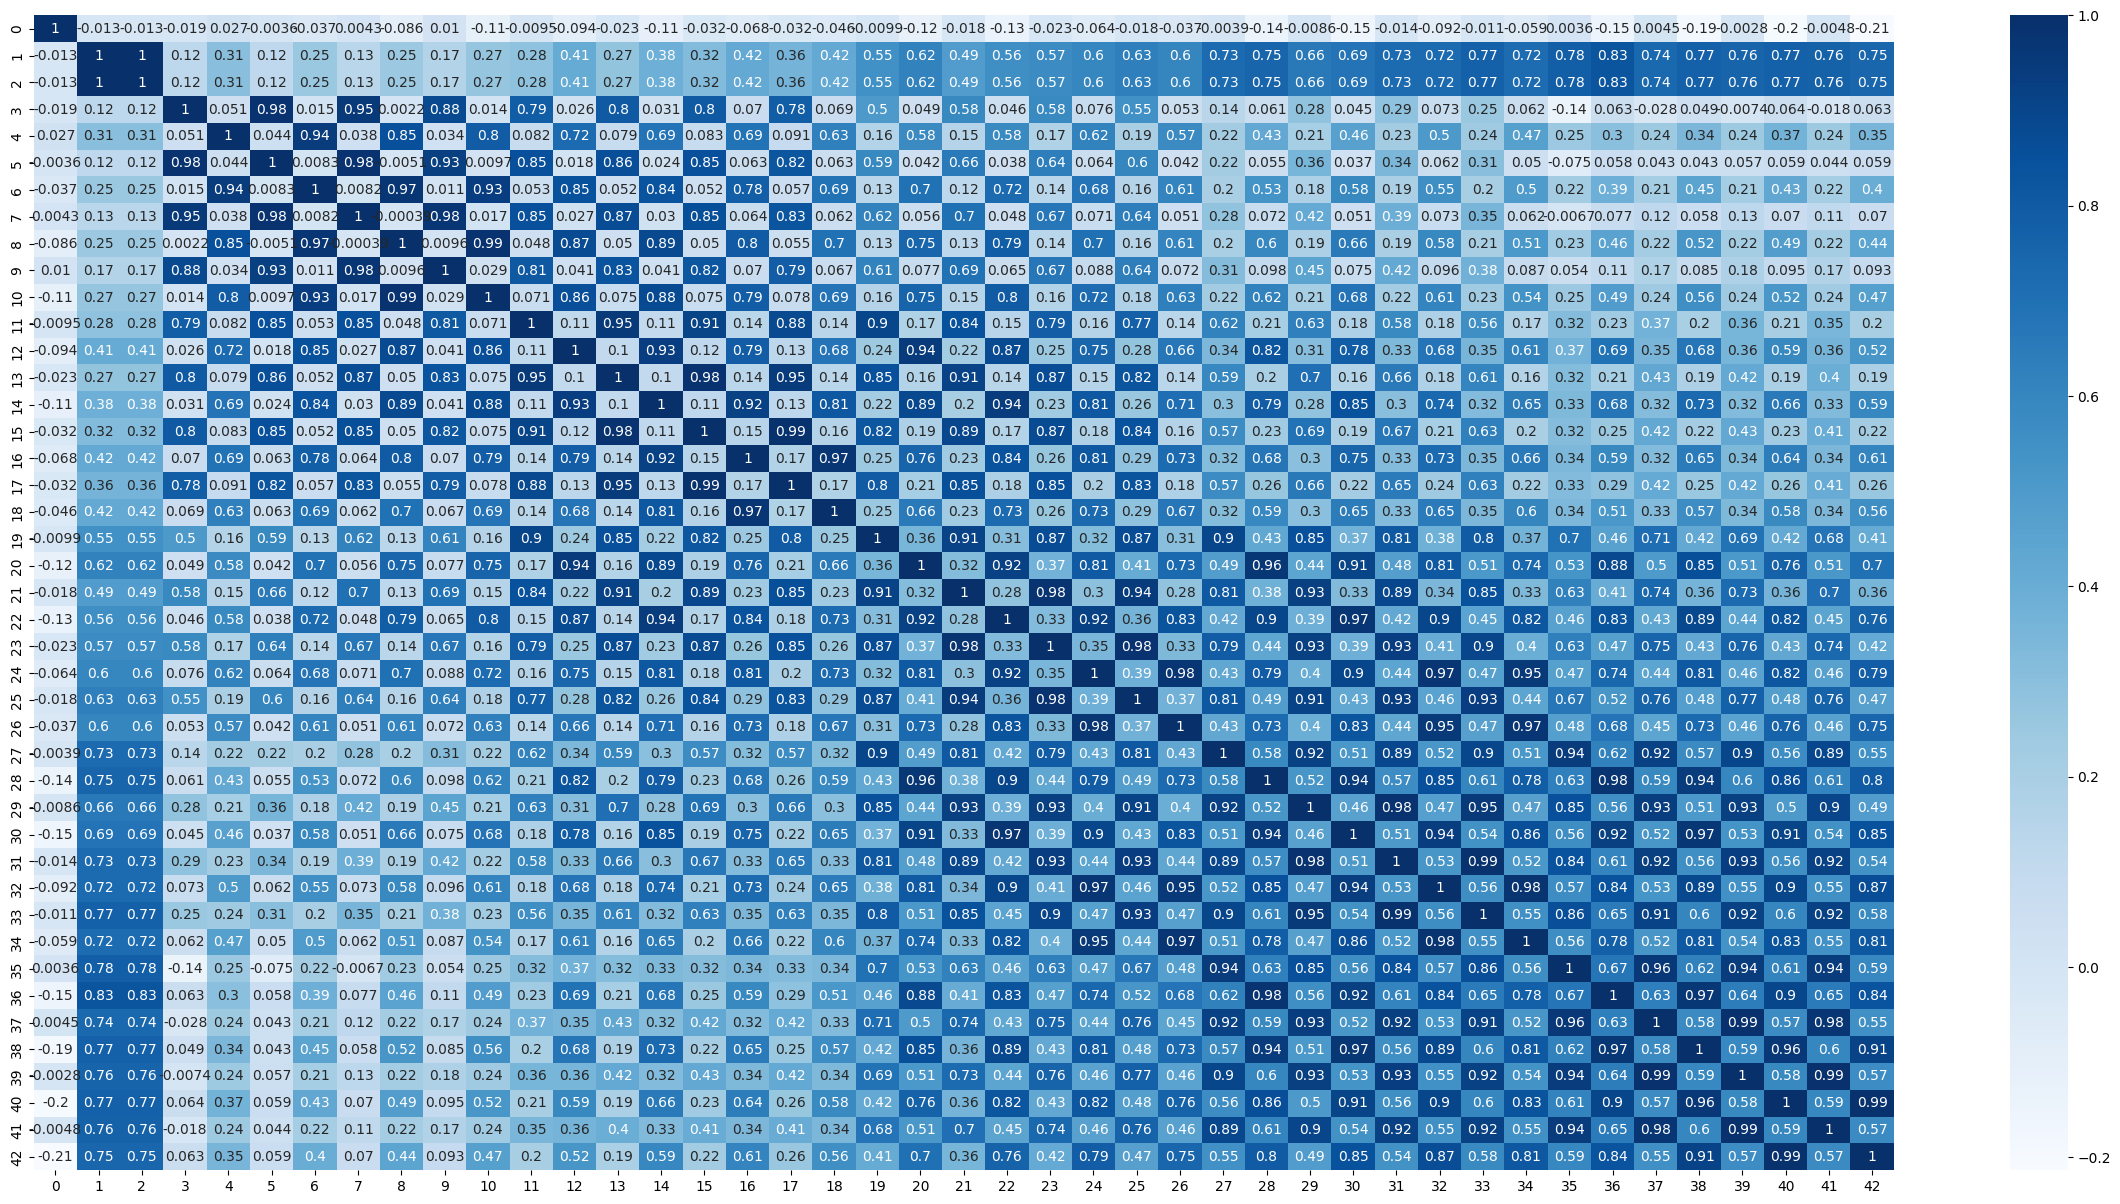

In [76]:
plt.figure(figsize = (30,15))
sns.heatmap(X_dataset_check.corr(numeric_only = True), annot = True, cmap = plt.cm.Blues)
plt.show()

# Model building

In [77]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [78]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [79]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False) # automatically save your model
# verbose : gọi lại thông báo mỗi khi thông báo
# save_weights_only: lưu lại cả mô hình lẫn thông số mô hình nếu False

# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)
# dừng quá trình đào tạo nếu hiệu suất mô hình ko đc cải thiện

In [80]:
# Model compilation
model.compile(
    optimizer='adam', # hàm tối ưu
    loss='sparse_categorical_crossentropy', # hàm mất mát
    metrics=['accuracy'] # thuước  đo đánh giá
)

# Model training

In [81]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
129/129 [==============================] - ETA: 0s - loss: 1.7923 - accuracy: 0.2132
Epoch 1: saving model to ../model/keypoint_classifier\keypoint_classifier.hdf5
129/129 [==============================] - 1s 5ms/step - loss: 1.7923 - accuracy: 0.2132 - val_loss: 1.7203 - val_accuracy: 0.2479
Epoch 2/1000
101/129 [======================>.......] - ETA: 0s - loss: 1.7084 - accuracy: 0.2926
Epoch 2: saving model to ../model/keypoint_classifier\keypoint_classifier.hdf5
129/129 [==============================] - 0s 2ms/step - loss: 1.6995 - accuracy: 0.2985 - val_loss: 1.5692 - val_accuracy: 0.4981
Epoch 3/1000
120/129 [==========================>...] - ETA: 0s - loss: 1.6090 - accuracy: 0.3482
Epoch 3: saving model to ../model/keypoint_classifier\keypoint_classifier.hdf5
129/129 [==============================] - 1s 8ms/step - loss: 1.6056 - accuracy: 0.3508 - val_loss: 1.4151 - val_accuracy: 0.6038
Epoch 4/1000
123/129 [===========================>..] - ETA: 0s - loss: 1.51

In [82]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

43/43 [==============================] - 0s 1ms/step - loss: 0.8031 - accuracy: 0.7412


In [83]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [84]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 111ms/step
[1.1326156e-03 3.5492954e-01 2.6305497e-01 1.3074779e-04 3.7972081e-01
 1.0313969e-03]
4


# Draw Loss and Accuracy

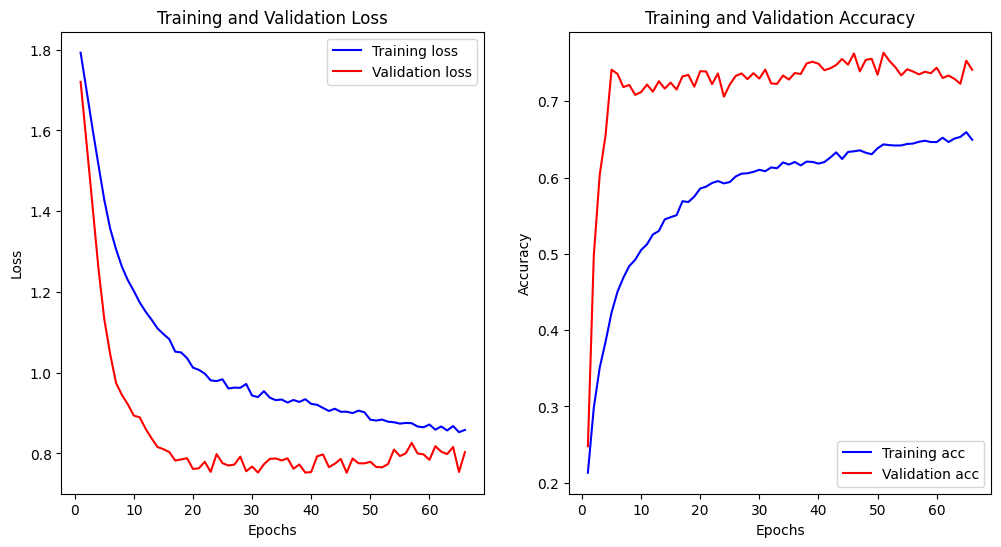

In [85]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Lấy thông tin về loss và accuracy từ history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Vẽ biểu đồ Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Vẽ biểu đồ Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)

# Confusion matrix

172/172 [==============================] - 0s 890us/step


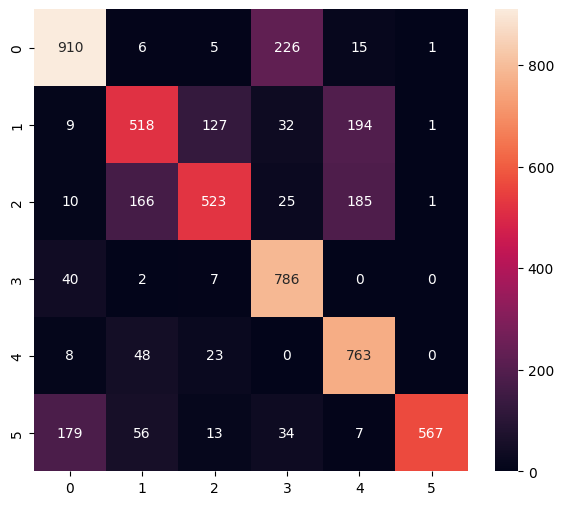

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      1163
           1       0.65      0.59      0.62       881
           2       0.75      0.57      0.65       910
           3       0.71      0.94      0.81       835
           4       0.66      0.91      0.76       842
           5       0.99      0.66      0.80       856

    accuracy                           0.74      5487
   macro avg       0.76      0.74      0.74      5487
weighted avg       0.76      0.74      0.74      5487



In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [87]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [88]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmpbpz8tx_s\assets


6632

# Inference test

In [89]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [90]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 42]), 'shape_signature': array([-1, 42]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [91]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [92]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [93]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.1326151e-03 3.5492951e-01 2.6305497e-01 1.3074772e-04 3.7972081e-01
 1.0313964e-03]
4
